#### On toymodules.
Compared to the sgan code, the toymodules dont have any type of pooling, i.e. the network does not know that agents are together in a scene. A very big __difference__ of __sgan__ and __toymodules__ to our __initial way to implement the modules__ is that the generator only __generates displacements__ and __loss is computed on displacements__.

#### Other remarks.
I renamed some variables for clarifying things:

- obs_taj -> xy_in
- obs_traj_rel -> dxdy_in
- pred_taj -> xy_out
- pred_traj_rel -> dxdy_out
- obs_len -> in_len
- pred_len -> out_len

Moreover, I commented some parts in sgan code and our code starting with "Important" and "Questions". In Pycharm you can go to Settings -> TODO and then create new keywords as TODO that will be highlighted in different colors. Thats super nice.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
from mapsgan import Solver, ToyGenerator, ToyDiscriminator, data_loader
import mapsgan.experiments as experiments
from mapsgan.evaluation import Visualization
import matplotlib.pyplot as plt

In [2]:
experiment = experiments.ETH() # we store filepaths and arguments in here
dataset, trainloader = data_loader(in_len=8, out_len=12, batch_size=64, num_workers=1, path=experiment.test_dir)

In [3]:
generator = ToyGenerator(in_len=8, out_len=12)
discriminator = ToyDiscriminator()

In [5]:
solver = Solver(generator, discriminator,  # pls read the code and docstrings to get the idea
                loss_fns={'norm': nn.L1Loss, 'gan': nn.BCEWithLogitsLoss},
                optims_args={'generator': {'lr': 1e-2}, 'discriminator': {'lr': 1e-2}})

In [6]:
solver.train(trainloader, epochs = 100, checkpoint_every=1, steps = {'generator': 1, 'discriminator': 1})

G_gan: 0.630	G_norm: 0.267	G_total: 0.897	D_real: 0.624	D_fake: 0.763	D_total: 1.387	
G_gan: 0.660	G_norm: 0.396	G_total: 1.056	D_real: 0.636	D_fake: 0.770	D_total: 1.406	
G_gan: 0.620	G_norm: 0.294	G_total: 0.913	D_real: 0.613	D_fake: 0.762	D_total: 1.375	
G_gan: 0.646	G_norm: 0.236	G_total: 0.882	D_real: 0.672	D_fake: 0.762	D_total: 1.434	
G_gan: 0.674	G_norm: 0.238	G_total: 0.912	D_real: 0.631	D_fake: 0.745	D_total: 1.376	
G_gan: 0.642	G_norm: 0.240	G_total: 0.882	D_real: 0.635	D_fake: 0.742	D_total: 1.377	
G_gan: 0.671	G_norm: 0.229	G_total: 0.900	D_real: 0.647	D_fake: 0.734	D_total: 1.381	
G_gan: 0.678	G_norm: 0.234	G_total: 0.912	D_real: 0.626	D_fake: 0.730	D_total: 1.356	
G_gan: 0.661	G_norm: 0.235	G_total: 0.896	D_real: 0.625	D_fake: 0.725	D_total: 1.350	
G_gan: 0.675	G_norm: 0.230	G_total: 0.905	D_real: 0.630	D_fake: 0.722	D_total: 1.351	
G_gan: 0.652	G_norm: 0.216	G_total: 0.868	D_real: 0.659	D_fake: 0.733	D_total: 1.391	
G_gan: 0.675	G_norm: 0.224	G_total: 0.900	D_real: 0.64

G_gan: 0.688	G_norm: 0.112	G_total: 0.800	D_real: 0.657	D_fake: 0.701	D_total: 1.357	
G_gan: 0.687	G_norm: 0.112	G_total: 0.799	D_real: 0.638	D_fake: 0.703	D_total: 1.340	
G_gan: 0.683	G_norm: 0.109	G_total: 0.792	D_real: 0.632	D_fake: 0.699	D_total: 1.332	
G_gan: 0.692	G_norm: 0.103	G_total: 0.795	D_real: 0.595	D_fake: 0.696	D_total: 1.291	


### Visualize things.
As we talked about, I implemented a simple plotting class that is supposed to integrate with the rest. E.g. vis.loss takes the dictionary 'solver.train_loss_history' of the solver object to plot all losses.
- For everything that you would like to visualize, think about how we could implement it in the class Visualization.

#### Losses

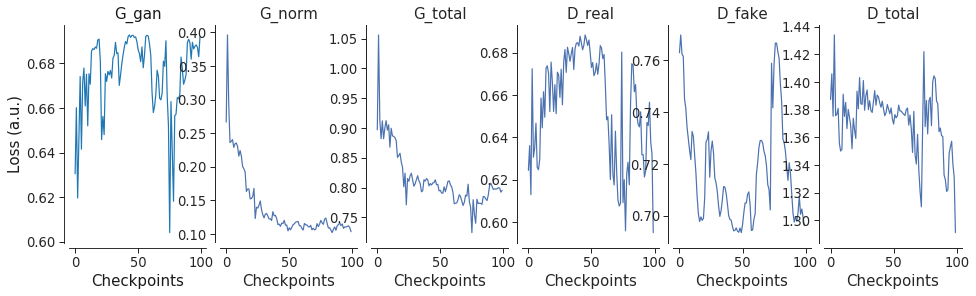

In [7]:
vis = Visualization()
vis.loss(solver.train_loss_history)

#### Trajectories

In [22]:
# get trajectories, dimensions are (scenes, sequence (in and pred), seq_len, num_agents, coordinates)
output = solver.test(trainloader)

(-1.81, 9.95)

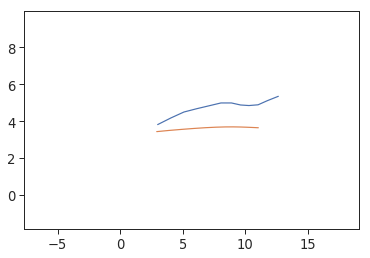

In [36]:
ymin = np.min([np.min(seq[:, :, 1]) for scene in output for seq in scene])
ymax = np.max([np.max(seq[:, :, 1]) for scene in output for seq in scene])
xmin = np.min([np.min(seq[:, :, 0]) for scene in output for seq in scene])
xmax = np.max([np.max(seq[:, :, 0]) for scene in output for seq in scene])
plt.plot(output[0][0][:, 1, 0], output[0][0][:, 1, 1])
plt.plot(output[0][1][:, 1, 0], output[0][1][:, 1, 1])
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

#### other

In [34]:
# get gt vs pred, dimensions are (scenes, sequence (out and pred), seq_len, num_agents, coordinates)
output = solver.test(trainloader, return_gt = True)

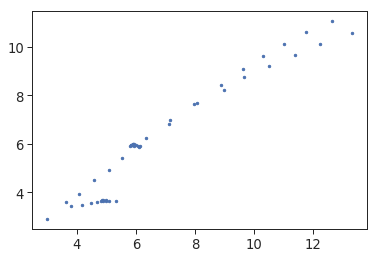

In [35]:
plt.plot(output[0][0].flatten(), output[0][1].flatten(), '.')